In [1]:
%env METAL_XCODE=1
%env DISABLE_COMPILER_CACHE=1

env: METAL_XCODE=1
env: DISABLE_COMPILER_CACHE=1


In [78]:
import numpy as np
from open3d import *
import matplotlib.pyplot as plt

from tinygrad import Tensor, dtypes
from scipy.spatial.transform import Rotation as R

In [57]:
point_cloud = io.read_point_cloud("../assets/Truck/sparse_pc.ply") # Read point cloud
point_cloud_array = np.asarray(point_cloud.points)
point_cloud_colors = np.asarray(point_cloud.colors)

# add one last 0 to the point_cloud array
point_cloud_array_homogeneous = np.hstack((point_cloud_array, np.ones((point_cloud_array.shape[0], 1))))

In [58]:
# We follow the convention K = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
# Rt = [[R | t], [0, 0, 0, 1]]
# where the final projection matrix is P = K * Rt

K = np.array([[256.0, 0.0, 0], [0.0, 256.0, 0], [0.0, 0.0, 1.0]])
Rt = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
P = np.dot(K, Rt)

print(P)


# scale of every gaussian
scale = np.array([0.05, 0.05, 0.05])
# rotation of every gaussian
rotation = np.array([0,0,0])
r = R.from_euler('xyz', rotation, degrees=False)
s = np.diag(scale)

covariance_camera = np.array([r.as_matrix() @ s @ s @ r.as_matrix().T])
covariance_camera = covariance_camera.repeat(point_cloud_array_homogeneous.shape[0], axis=0)


[[256.   0.   0.   0.]
 [  0. 256.   0.   0.]
 [  0.   0.   1.   0.]]


In [79]:
point_camera = np.dot(P, point_cloud_array_homogeneous.T).T

# Get x and y coordinates
x = point_camera[:, 0]
y = point_camera[:, 1]
z = point_camera[:, 2]

print(x.shape)

means_x = np.array([x]) / -(z**2)
means_y = np.array([y]) / -(z**2)

means_stacked = np.stack((means_x, means_y), axis=1).T
# print(means_stacked)

sigma_n = Rt[:,:3] @ covariance_camera @ Rt[:,:3].T


eyes = np.array([np.eye(2)]).repeat(point_cloud_array_homogeneous.shape[0], axis=0)
eyes = eyes / (-z.reshape(-1, 1, 1))
J = np.concatenate((eyes, means_stacked), axis=2)

print(J)

(136614,)
[[[ 8.75304934e-01  0.00000000e+00 -4.53641676e+02]
  [ 0.00000000e+00  8.75304934e-01 -2.36114380e+02]]

 [[ 8.50672159e-01  0.00000000e+00 -4.87634779e+02]
  [ 0.00000000e+00  8.50672159e-01 -1.47530756e+02]]

 [[ 8.26772890e-01  0.00000000e+00 -3.87435887e+02]
  [ 0.00000000e+00  8.26772890e-01 -8.65292438e+01]]

 ...

 [[-5.27509627e+00 -0.00000000e+00  1.22150422e+05]
  [-0.00000000e+00 -5.27509627e+00 -1.06975102e+05]]

 [[ 2.23454200e+00  0.00000000e+00  2.44727522e+03]
  [ 0.00000000e+00  2.23454200e+00 -1.66918567e+03]]

 [[ 1.95235855e+00  0.00000000e+00 -9.50068355e+02]
  [ 0.00000000e+00  1.95235855e+00  1.10664949e+03]]]


In [76]:
sigma_n

array([[[0.0025, 0.    , 0.    ],
        [0.    , 0.0025, 0.    ],
        [0.    , 0.    , 0.0025]],

       [[0.0025, 0.    , 0.    ],
        [0.    , 0.0025, 0.    ],
        [0.    , 0.    , 0.0025]],

       [[0.0025, 0.    , 0.    ],
        [0.    , 0.0025, 0.    ],
        [0.    , 0.    , 0.0025]],

       ...,

       [[0.0025, 0.    , 0.    ],
        [0.    , 0.0025, 0.    ],
        [0.    , 0.    , 0.0025]],

       [[0.0025, 0.    , 0.    ],
        [0.    , 0.0025, 0.    ],
        [0.    , 0.    , 0.0025]],

       [[0.0025, 0.    , 0.    ],
        [0.    , 0.0025, 0.    ],
        [0.    , 0.    , 0.0025]]])

In [77]:
covariance_2d = J @ sigma_n @ J.transpose(0, 2, 1)

width = 256
height = 256

# Create mask for points inside the image boundaries
mask = (x >= 0) & (x < width) & (y >= 0) & (y < height)

# Apply mask to x, y, and colors
x_in = x[mask]
y_in = y[mask]
colors = point_cloud_colors[mask]
covariance_2d = covariance_2d[mask]
covariance_2d

array([[[1.17561139e+03, 5.50834486e+03],
        [5.50834486e+03, 2.58102999e+04]],

       [[2.40287746e+02, 2.11333862e+03],
        [2.11333862e+03, 1.85892824e+04]],

       [[6.07357276e+06, 7.41308271e+06],
        [7.41308271e+06, 9.04801941e+06]],

       ...,

       [[8.18393053e+01, 6.89469029e+01],
        [6.89469029e+01, 5.80889223e+01]],

       [[1.53623457e+06, 1.66117741e+06],
        [1.66117741e+06, 1.79628253e+06]],

       [[8.79719234e+01, 6.00187247e+02],
        [6.00187247e+02, 4.09550294e+03]]])

In [63]:
print(x.shape)
print(x_in.shape)

print(x_in.max())

(136614,)
(2670,)
255.988224


In [69]:
images_n = 2670
x_new = x_in[:images_n]
y_new = y_in[:images_n]
colors_new = colors[:images_n]
covariance_2d_new = covariance_2d[:images_n]

print(x_new.shape)
print(y_new.shape)
print(colors_new.shape)
print(covariance_2d_new.shape)
covariance_2d_new

(2670,)
(2670,)
(2670, 3)
(2670, 2, 2)


array([[[1.17561139e+03, 5.50834486e+03],
        [5.50834486e+03, 2.58102999e+04]],

       [[2.40287746e+02, 2.11333862e+03],
        [2.11333862e+03, 1.85892824e+04]],

       [[6.07357276e+06, 7.41308271e+06],
        [7.41308271e+06, 9.04801941e+06]],

       ...,

       [[8.18393053e+01, 6.89469029e+01],
        [6.89469029e+01, 5.80889223e+01]],

       [[1.53623457e+06, 1.66117741e+06],
        [1.66117741e+06, 1.79628253e+06]],

       [[8.79719234e+01, 6.00187247e+02],
        [6.00187247e+02, 4.09550294e+03]]])

In [65]:
def generate_splat(coordinates, colors, covariance, img_size):
    kernel_size = img_size[0]
        
    W = img_size[0] # width of the image
    H = img_size[1] # height of the image
    batch_size = colors.shape[0] # number of Gaussians defined above

    inv_covariance, covariance_det = get_inverse_batched(covariance)

    x = np.linspace(-5, 5, kernel_size)
    y = np.linspace(-5, 5, kernel_size)
    yy, xx = Tensor(np.meshgrid(x, y))
    yy = yy.expand(batch_size, -1, -1)
    
    xx = xx.expand(batch_size, -1, -1)    

    xx = xx + coordinates[:,0].unsqueeze(1).unsqueeze(1) * 5
    yy = yy + coordinates[:,1].unsqueeze(1).unsqueeze(1) * 5

    xy = xx.stack(yy, dim=-1)
    z = Tensor.einsum('bxyi,bij,bxyj->bxy', xy, -0.5 * inv_covariance, xy)

    kernel = z.exp() / np.pi * covariance_det.sqrt().view(batch_size, 1, 1)
    kernel_max = kernel.max(axis=(1,2), keepdim=True) + 1e-6 # avoid division by zero
    kernel_norm = kernel / kernel_max 

    kernel_rgb = kernel_norm.unsqueeze(1).expand(-1, 3, -1, -1)
    rgb_values_reshaped = colors.unsqueeze(1).unsqueeze(1).permute(0,3,1,2)

    final_image_layers = rgb_values_reshaped * kernel_rgb    

    final_image = final_image_layers.sum(axis=0)

    final_image = final_image.clamp(0, 1)
    final_image = final_image.permute(1,2,0)

    return final_image

def get_inverse_batched(matrices):

    a = matrices[:,0,0]
    b = matrices[:,0,1]
    c = matrices[:,1,0]
    d = matrices[:,1,1]    

    det = a*d - b*c    

    d_new = d.unsqueeze(1)
    b_new = -b.unsqueeze(1)
    a_new = a.unsqueeze(1)
    c_new = -c.unsqueeze(1)

    top = d_new.cat(b_new, dim=1).unsqueeze(1)
    bottom = c_new.cat(a_new, dim=1).unsqueeze(1)

    inverse = top.stack(bottom, dim=2).reshape(-1,2,2) 
    inverse = inverse * (1.0 / det).unsqueeze(1).unsqueeze(1)

    return inverse, det

In [66]:
x_new.max()

255.988224

In [80]:
coordinates = (Tensor(np.stack((x_new, y_new), axis=1), dtype=dtypes.float32) - 128.0) /128.0
coordinates.numpy()

covariances_simple = np.array([[[0.0001, 0], [0, 0.0001]]]).repeat(images_n, axis=0)

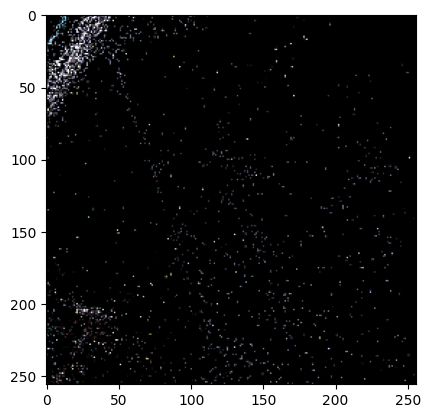

In [81]:
image = generate_splat(coordinates, Tensor(colors_new, dtype=dtypes.float32), Tensor(covariances_simple, dtype=dtypes.float32), (width, height))     

plt.imshow(image.numpy())